# Importing libraries

In [1]:
import pandas as pd
import re
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
movies=pd.read_csv('movies.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.describe

<bound method NDFrame.describe of        movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
62418   209157                           We (2018)   
62419   209159           Window of the Soul (2001)   
62420   209163                    Bad Poems (2018)   
62421   209169                 A Girl Thing (2001)   
62422   209171      Women of Devil's Island (1962)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


# Data Preprocessing

In [6]:
def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    return title

In [7]:
movies["clean_title"] = movies["title"].apply(clean_title)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(movies["clean_title"])

In [9]:

def search(title):
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -5)[-5:]
    results = movies.iloc[indices].iloc[::-1]

    return results

In [10]:

movie_input = widgets.Text(
    value='Toy Story',
    description='Movie Title:',
    disabled=False
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(on_type, names='value')



In [11]:
movie_id = 89745

#def find_similar_movies(movie_id):
movie = movies[movies["movieId"] == movie_id]

In [12]:

ratings = pd.read_csv("ratings.csv")

In [13]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [14]:
similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4)]["userId"].unique()

In [15]:
similar_user_recs = ratings[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4)]["movieId"]

In [16]:
similar_user_recs = similar_user_recs.value_counts() / len(similar_users)

similar_user_recs = similar_user_recs[similar_user_recs > .10]

In [17]:
all_users = ratings[(ratings["movieId"].isin(similar_user_recs.index)) & (ratings["rating"] > 4)]
all_user_recs = all_users["movieId"].value_counts() / len(all_users["userId"].unique())

In [18]:
rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
rec_percentages.columns = ["similar", "all"]

In [19]:
rec_percentages

,similar,all
89745,1.000000,0.040459
58559,0.573393,0.148256
59315,0.530649,0.054931
79132,0.519715,0.132987
2571,0.496687,0.247010
...,...,...
47610,0.103545,0.022770
780,0.103380,0.054723
88744,0.103048,0.010383
1258,0.101226,0.083887


In [20]:
rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]

In [21]:
rec_percentages = rec_percentages.sort_values("score", ascending=False)


In [22]:
rec_percentages.head(10).merge(movies, left_index=True, right_on="movieId")

,similar,all,score,movieId,title,genres,clean_title
17067,1.000000,0.040459,24.716368,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,Avengers The 2012
20513,0.103711,0.005289,19.610199,106072,Thor: The Dark World (2013),Action|Adventure|Fantasy|IMAX,Thor The Dark World 2013
25058,0.241054,0.012367,19.491770,122892,Avengers: Age of Ultron (2015),Action|Adventure|Sci-Fi,Avengers Age of Ultron 2015
19678,0.216534,0.012119,17.867419,102125,Iron Man 3 (2013),Action|Sci-Fi|Thriller|IMAX,Iron Man 3 2013
16725,0.215043,0.012052,17.843074,88140,Captain America: The First Avenger (2011),Action|Adventure|Sci-Fi|Thriller|War,Captain America The First Avenger 2011
16312,0.175447,0.010142,17.299824,86332,Thor (2011),Action|Adventure|Drama|Fantasy|IMAX,Thor 2011
21348,0.287608,0.016737,17.183667,110102,Captain America: The Winter Soldier (2014),Action|Adventure|Sci-Fi|IMAX,Captain America The Winter Soldier 2014
25071,0.214049,0.012856,16.649399,122920,Captain America: Civil War (2016),Action|Sci-Fi|Thriller,Captain America Civil War 2016
25061,0.136017,0.008573,15.865628,122900,Ant-Man (2015),Action|Adventure|Sci-Fi,AntMan 2015
14628,0.242876,0.015517,15.651921,77561,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX,Iron Man 2 2010


# Data Visualization

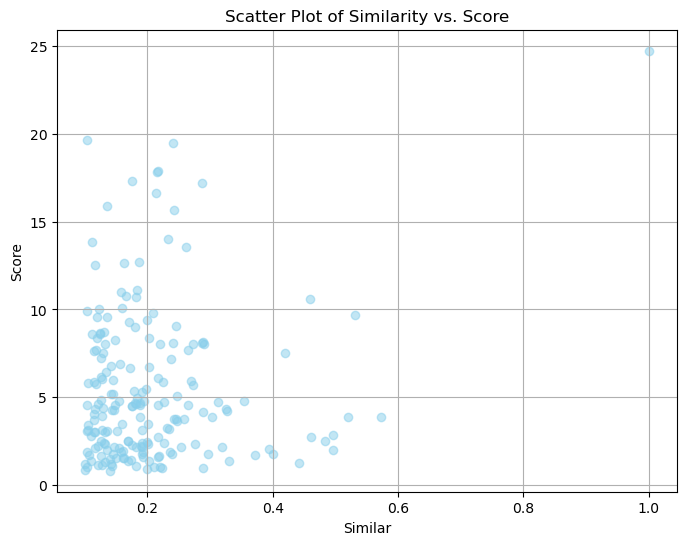

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(rec_percentages['similar'], rec_percentages['score'], color='skyblue', alpha=0.5)
plt.xlabel('Similar')
plt.ylabel('Score')
plt.title('Scatter Plot of Similarity vs. Score')
plt.grid(True)
plt.show()

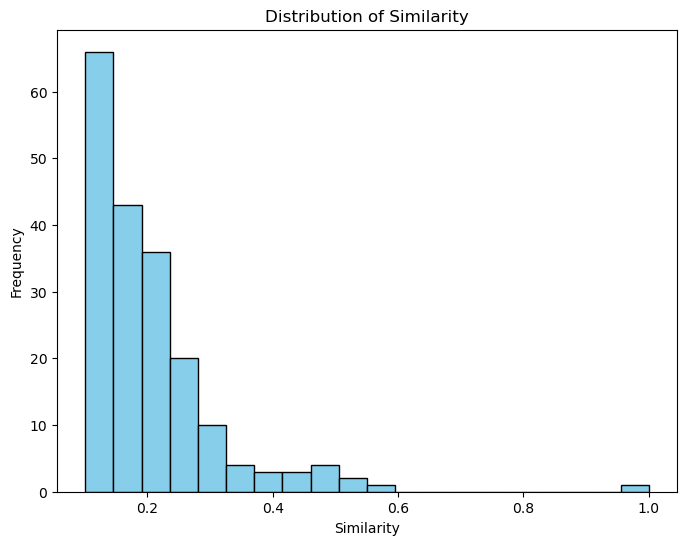

In [24]:
plt.figure(figsize=(8, 6))
plt.hist(rec_percentages['similar'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity')
plt.show()

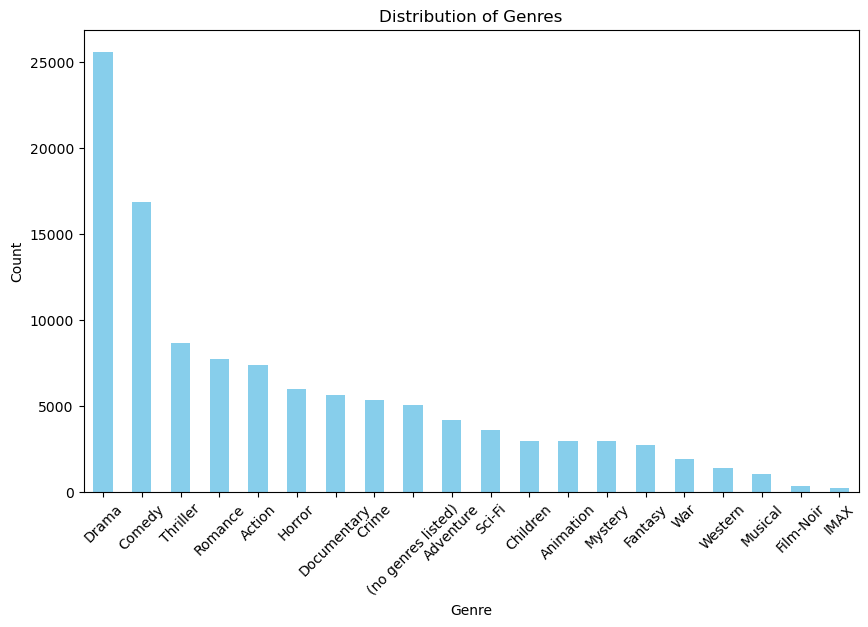

In [25]:
import matplotlib.pyplot as plt

# Split genres into individual genres
genres = movies['genres'].str.split('|', expand=True).stack()

# Plot bar plot for genre distribution
plt.figure(figsize=(10, 6))
genres.value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Distribution of Genres')
plt.xticks(rotation=45)
plt.show()

In [26]:
def find_similar_movies(movie_id):
    similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4)]["userId"].unique()
    similar_user_recs = ratings[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4)]["movieId"]
    similar_user_recs = similar_user_recs.value_counts() / len(similar_users)

    similar_user_recs = similar_user_recs[similar_user_recs > .10]
    all_users = ratings[(ratings["movieId"].isin(similar_user_recs.index)) & (ratings["rating"] > 4)]
    all_user_recs = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
    rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
    rec_percentages.columns = ["similar", "all"]

    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    rec_percentages = rec_percentages.sort_values("score", ascending=False)
    return rec_percentages.head(10).merge(movies, left_index=True, right_on="movieId")[["score", "title", "genres"]]

In [27]:
import ipywidgets as widgets
from IPython.display import display

movie_name_input = widgets.Text(
    value='Enter movie Title',
    description='Movie Title:',
    disabled=False
)
recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            results = search(title)
            movie_id = results.iloc[0]["movieId"]
            display(find_similar_movies(movie_id))

movie_name_input.observe(on_type, names='value')

display(movie_name_input, recommendation_list)


Text(value='Enter movie Title', description='Movie Title:')

Output()